In [8]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os
import cartopy.crs as ccrs
import numpy as np
import pandas as pd


def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


#  Understand land surface data
##  1.  Load the landsurface data

In [9]:
fsurdat: str = "/home/jguo/projects/cesm/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc"
# Load the dataset
ds_sur = xr.open_mfdataset(fsurdat)
ds_sur

<xarray.Dataset>
Dimensions:                  (lsmlat: 192, lsmlon: 288, nlevsoi: 10,
                              natpft: 15, cft: 2, time: 12, lsmpft: 17,
                              numurbl: 3, numrad: 2, nlevurb: 5, nglcecp1: 11,
                              nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, numurbl,
                                numrad, nlevurb, nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 dask.array<chunksize=(10, 192, 288), meta=np.ndarray>
    FMAX                     (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_GRAZING            (lsmlat, lsmlon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 dask.array<chunksize=(15, 192, 288), meta=np.ndarray>
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 dask.array<chunksize=(2, 192, 288), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:19
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_0.9x1.25_nomas...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

In [10]:
# Access the PCT_URBAN variable
pct_urban = ds_sur['PCT_URBAN']
pct_urban

<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lsmlat: 192, lsmlon: 288)>
dask.array<open_dataset-PCT_URBAN, shape=(3, 192, 288), dtype=float64, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Dimensions without coordinates: numurbl, lsmlat, lsmlon
Attributes:
    long_name:  percent urban for each density type
    units:      unitless


##  2.  Determine which grid is Urban

In [11]:
# Access the PCT_URBAN variable
pct_urban = ds_sur['PCT_URBAN']
pct_urban
# Sum across the 'numurbl' dimension to get total urban coverage

<xarray.DataArray 'PCT_URBAN' (numurbl: 3, lsmlat: 192, lsmlon: 288)>
dask.array<open_dataset-PCT_URBAN, shape=(3, 192, 288), dtype=float64, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Dimensions without coordinates: numurbl, lsmlat, lsmlon
Attributes:
    long_name:  percent urban for each density type
    units:      unitless

In [12]:

# https://bb.cgd.ucar.edu/cesm/threads/proportion-of-cities-in-surface-data.8046/
# PCT_URBAN is the percent of each urban density type. The density types in order are
# tall building district (TBD), high density (HD), and medium density (MD).
# If you change those percentages, e.g, increase them, then you'll need to decrease
# some other surface type (e.g., PCT_NATVEG, PCT_CROP, PCT_LAKE, etc.).
# The sum of PCT_URBAN, PCT_NATVEG, PCT_CROP, PCT_LAKE, PCT_GLACIER, PCT_WETLAND needs to be 100%.
# PCT_URBAN has multiple layers for different urban density types, sum across the 'numurbl' dimension to get total urban coverage
total_urban_pct = pct_urban.sum(dim='numurbl')
total_urban_pct

<xarray.DataArray 'PCT_URBAN' (lsmlat: 192, lsmlon: 288)>
dask.array<sum-aggregate, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Dimensions without coordinates: lsmlat, lsmlon


##  3.  Create a mask for the urban grid, the mask is variable masked_urban_areas

In [13]:
# Sum across the 'numurbl' dimension to get total urban coverage

# https://bb.cgd.ucar.edu/cesm/threads/proportion-of-cities-in-surface-data.8046/
# PCT_URBAN is the percent of each urban density type. The density types in order are
# tall building district (TBD), high density (HD), and medium density (MD).
# If you change those percentages, e.g, increase them, then you'll need to decrease
# some other surface type (e.g., PCT_NATVEG, PCT_CROP, PCT_LAKE, etc.).
# The sum of PCT_URBAN, PCT_NATVEG, PCT_CROP, PCT_LAKE, PCT_GLACIER, PCT_WETLAND needs to be 100%.
# PCT_URBAN has multiple layers for different urban density types, sum across the 'numurbl' dimension to get total urban coverage
total_urban_pct = pct_urban.sum(dim='numurbl')

# Filter locations where total urban percentage is greater than 2%
# Using .where() to retain the data structure and metadata
masked_urban_areas = total_urban_pct.where(total_urban_pct > 2)


def find_top_urban_areas(masked_urban_areas):
    # Convert the stacked DataArray to a pandas DataFrame
    df = masked_urban_areas.stack(z=('lsmlat', 'lsmlon')).to_dataframe(name='urban_pct')

    # Use the nlargest method on the DataFrame to find the top 50 values
    top_urban_areas_df = df.nlargest(50, 'urban_pct')
    # Drop the redundant 'lsmlat' and 'lsmlon' columns
    top_urban_areas_df = top_urban_areas_df.drop(columns=['lsmlat', 'lsmlon'])

    return top_urban_areas_df


# Call the function with the masked_urban_areas variable
top_urban_areas = find_top_urban_areas(masked_urban_areas)
print(top_urban_areas)

masked_urban_areas.count() / (192 * 288)

               urban_pct
lsmlat lsmlon           
135    2       55.611619
104    63      50.000000
132    28      48.645890
59     21      41.867101
58     243     40.578987
90     9       36.724269
133    112     35.587411
140    25      35.364088
128    25      34.218028
104    58      34.168117
139    2       33.720860
132    282     33.393325
107    59      33.333333
140    218     33.317939
116    58      32.948605
95     223     30.613177
151    3       30.387382
150    0       29.279365
131    193     28.873214
149    0       27.881184
109    223     26.663272
129    24      26.502659
126    62      25.918830
89     85      25.912425
120    71      24.923125
150    6       24.385361
130    194     23.855810
132    108     23.472601
89     86      23.454897
123    224     23.350594
71     253     22.688645
101    0       22.512972
149    287     22.168313
152    286     21.974364
105    61      21.445361
109    240     21.396564
70     251     21.223382
114    67      21.016264


<xarray.DataArray 'PCT_URBAN' ()>
dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


##  4.  Plot the urban grid

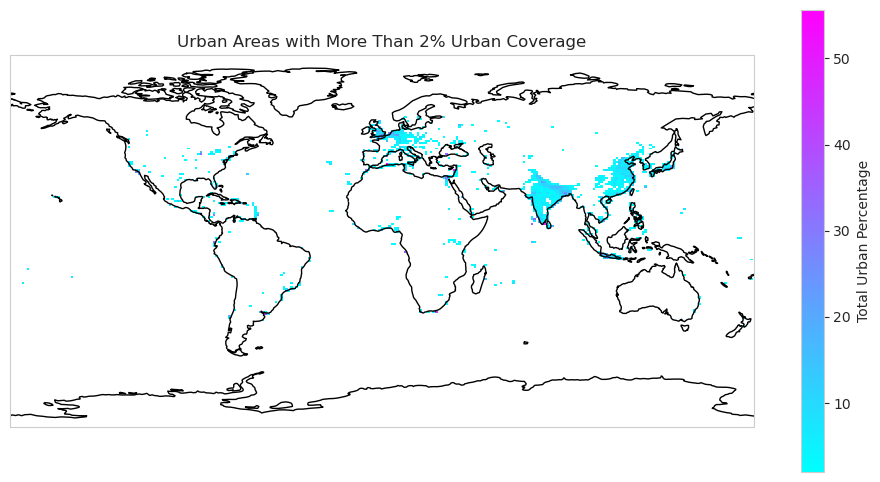

In [14]:
# Plotting
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Get longitude and latitude information from the dataset
longitude = ds_sur['LONGXY']
latitude = ds_sur['LATIXY']

# Plotting the urban areas that meet the condition
# Note: masked_urban_areas already has values below 2% filtered out, so we use it directly
plt.pcolormesh(longitude, latitude, masked_urban_areas, transform=ccrs.PlateCarree(), cmap='cool') #cmap='cool') cmap='Reds')

plt.colorbar(label='Total Urban Percentage')
plt.title('Urban Areas with More Than 2% Urban Coverage')
plt.show()


#  Define HW Temporal filter
##  1.  Load the daily(h1 tape) simulation temperature data

Load the dataset, I copied the files to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/daily_raw it is 137G in total
I run the utils/extrac_hw_data.py to extract the data to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/daily_raw
and save the data to /home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary

In [ ]:
# Open the NetCDF file using xarray
hw_summary_dir = '/home/jguo/process_data/i.e215.I2000Clm50SpGs.hw_production.02/summary'
hw_input_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.TSA_UR_TREFMXAV_R.nc'
hw_file_path = os.path.join(hw_summary_dir, hw_input_file)
ds_hw = xr.open_dataset(hw_file_path)
ds_hw




##  2   For the masked grid(Urban grid) find temp periods that satisfy the HW definition.

We use the definition from the US National Weather Service (NWS): three or more consecutive days ofmaximumtemperature reaching at least 90 ◦F (32.2 ◦C). 
We consider that, in each grid cell (a size on the order of 100 × 100 km), its rural sub-grid represents a local background environment for the city. 
Therefore, for each city we use its rural 2m-height temperature (T2m,rural) to define HWs.

We use this variable in the daily h1 file: TREFMXAV_R:long_name = "Rural daily maximum of average 2-m temperature" ;

In [ ]:
# Convert 90 degrees Fahrenheit to Kelvin
fahrenheit_threshold = 90
kelvin_threshold = (fahrenheit_threshold - 32) * (5/9) + 273.15

# Define a function to apply on each grid cell to detect heatwaves
def detect_heatwave(tsa_r):
    # Convert to a numpy array
    tsa_r_np = tsa_r.values

    # Initialize an array for HW with the same shape, filled with NaN
    hw = np.full_like(tsa_r_np, np.nan)

    # Iterate through time steps, starting from the 2nd index for comparison
    for time in range(2, tsa_r_np.shape[0]):
        # Check for 3 consecutive days above the threshold
        if (tsa_r_np[time-2] > kelvin_threshold and
                tsa_r_np[time-1] > kelvin_threshold and
                tsa_r_np[time] > kelvin_threshold):
            hw[time-2:time+1] = 1  # Mark as heatwave
    return hw

# Apply the function along the time dimension for each grid cell
hw = xr.apply_ufunc(detect_heatwave, ds_hw['TREFMXAV_R'],
                    input_core_dims=[['time']],
                    vectorize=True,
                    dask='parallelized',
                    output_dtypes=[float])

# Assign the HW data back to the original dataset as a new variable
ds_hw['HW'] = hw

# Optional: save the modified dataset to a new NetCDF file
hw_output_file = 'i.e215.I2000Clm50SpGs.hw_production.02.clm2.h1.hw.nc'
hw_file_path = os.path.join(hw_summary_dir, hw_output_file)
ds_hw.to_netcdf('hw_output_file')

# Make sure to close the dataset if you're done with it
ds_hw



##  3.  The outcome should be 2D array with 1 for HW day and 0 for non HW day, the xarray should daily time dimension.
##  4.  Check those dates in against definition of global summer
###  4.1 make sure we do north and south hemisphere correctly
##  5. Compute the "HW days for Any grid" list of dates. I need to load file on that day if any grid has a HW day.  


#  Process hourly simulation output data
##  1. Load the hourly simulation temperature data from "HW days for Any grid" list of dates
##  2. Convert UTC to local time 
##  3. Compute the UHI for 2m air T for each HW grid
##  4. Compute the UWBI for surface for each HW grid

#  Analyzing outcomes, figuring out what are the factors that is driving the UHI and UWBI
##  1.  feature engineering, the right hand side factors
###  1.1  humidity(precipitation))
###  1.2  distance to shore (what about big lakes)?
###  1.3  Different part of day (morning, afternoon, evening, night)
###  1.4  Surface roughness, albedo, vegetation

